# Analysis of NYC Taxi Cab Data

## Import Libraries and Connect to Database

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Connect to database:
con = sqlite3.connect("NYC-Taxi.db")

## Extract Observations and Clean Data

We will extract a sample of 1,000,000 observations consisting of green and yellow cab data to explore the characteristics of taxi rides in NYC's boroughs and surrounding areas.

In [2]:
# Store sample of green and yellow cab data into dataframes:
df1 = pd.read_sql(f"SELECT * FROM green_cabs ORDER BY random() LIMIT 500000", con)
df2 = pd.read_sql(f"SELECT * from yellow_cabs ORDER BY random() LIMIT 500000", con)

# Add labels for green and yellow cabs and rename pickup/dropoff datetime columns:
df1 = df1.rename(columns={"lpep_pickup_datetime": "pickup_datetime", "lpep_dropoff_datetime":"dropoff_datetime"})
df2 = df2.rename(columns={"tpep_pickup_datetime": "pickup_datetime", "tpep_dropoff_datetime":"dropoff_datetime"})
df1['cab'] = "green"
df2['cab'] = "yellow"

# Combine into one data frame:
frames = [df1, df2]
df = pd.concat(frames)

# Change format to datetime where necessary:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],unit='s')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'],unit='s')

df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Source_file,cab
0,NaN,2019-09-18 12:21:00,2019-09-18 12:54:00,None,NaN,140,61,NaN,10.25,34.12,...,0.00,0.0,NaN,0.3,37.67,NaN,NaN,NaN,green_tripdata_2019-09.csv,green
1,2.0,2019-07-03 09:51:55,2019-07-03 10:00:08,N,1.0,7,129,1.0,1.30,7.00,...,0.00,0.0,NaN,0.3,7.80,2.0,1.0,0.00,green_tripdata_2019-07.csv,green
2,1.0,2019-09-03 17:21:31,2019-09-03 17:32:35,N,1.0,166,43,1.0,1.40,9.00,...,1.50,0.0,NaN,0.3,12.30,1.0,1.0,0.00,green_tripdata_2019-09.csv,green
3,1.0,2019-02-08 15:30:20,2019-02-08 15:40:40,N,1.0,74,152,1.0,1.30,8.50,...,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00,green_tripdata_2019-02.csv,green
4,2.0,2019-04-03 21:06:57,2019-04-03 21:28:44,N,1.0,66,161,1.0,7.27,23.00,...,5.41,0.0,NaN,0.3,32.46,1.0,1.0,2.75,green_tripdata_2019-04.csv,green


## Feature Engineering

To better understand the data, we will add the following features to the main dataset:

* Borough = the borough the passenger is picked up in.
* Zone = the zone the passenger is picked up in (e.g. East Elmhurst).
* trip_time = total trip time.
* trip_speed = average speed of the trip (in miles per hour).
* tip_indicator = indicates whether a passenger tips (1 or 0).
* holiday_* = indicates whether the ride was on a holiday.
* hour_* = hour of day of the trip.
* day = day of the pickup.

In [3]:
# Include pickup borough:

#Store Pickup location borough names and merge to main data frame:
df_location = pd.read_csv("/Users/mbp/Documents/Side Projects/NYC Taxi Cab Scratch/taxi+_zone_lookup.csv")
df_location['DOLocationID'] = df_location['LocationID']
df_location = df_location.rename(columns = {'LocationID':'PULocationID'})

# Add borough and Zone name:
df = df.merge(df_location[['PULocationID', 'Borough', 'Zone']], on = "PULocationID", how = 'left')

# Include trip time:
df['trip_time'] = (df['dropoff_datetime'] - df['pickup_datetime']).astype('timedelta64[m]')

# Include trip speed:
df['trip_speed'] = ((df['trip_distance'])/(df['trip_time']))*60

# Create day of pickup:
df['day'] = df['pickup_datetime'].dt.day_name()

# Create tip indicator (1 = passenger tips, 0 = doesn't):
df['tip_indicator'] = [0 if x =='0' else 1 for x in df['tip_amount']] 

cal = calendar()
df['date'] = pd.to_datetime(df['dropoff_datetime']).dt.date
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max(), return_name=True)
holidays = holidays.reset_index(name='holiday').rename(columns={'index':'date'})
holidays['date'] = pd.to_datetime(holidays['date']).dt.date
df = pd.merge(df, holidays, on = 'date', how='left')

# create dummys for holiday:
df = pd.get_dummies(df,dummy_na= True, columns= ['holiday'])

# Add NYE holiday:
df['holiday_NYE'] = np.where((pd.to_datetime(df['date']).dt.month == 12) & \
                     (pd.to_datetime(df['date']).dt.day == 31), 1, 0)

# Add hour of day variable:
hour = pd.get_dummies(df['pickup_datetime'].dt.hour, dummy_na= True)
hour.columns = ['hour_' + str(col) for col in hour.columns]
df = pd.concat([df, hour], axis=1)

df.head()

,VendorID,pickup_datetime,dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0,hour_nan
0,NaN,2019-09-18 12:21:00,2019-09-18 12:54:00,None,NaN,140,61,NaN,10.25,34.12,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2019-07-03 09:51:55,2019-07-03 10:00:08,N,1.0,7,129,1.0,1.30,7.00,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2019-09-03 17:21:31,2019-09-03 17:32:35,N,1.0,166,43,1.0,1.40,9.00,...,0,0,1,0,0,0,0,0,0,0
3,1.0,2019-02-08 15:30:20,2019-02-08 15:40:40,N,1.0,74,152,1.0,1.30,8.50,...,1,0,0,0,0,0,0,0,0,0
4,2.0,2019-04-03 21:06:57,2019-04-03 21:28:44,N,1.0,66,161,1.0,7.27,23.00,...,0,0,0,0,0,0,1,0,0,0


## Exploratory Data Analysis

We will examine summary statistics of all variables to get a better look at the structure of the data, and to see if there are apparent outliers.

In [4]:
# Summary stats and structure of data:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,...,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0,hour_nan
count,964115.000000,964115.000000,1000000.000000,1000000.000000,964115.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0
mean,1.741143,1.121789,135.749320,145.156132,1.439662,3.144472,13.837923,0.811668,0.488789,1.588006,...,0.058694,0.059057,0.064085,0.067616,0.062280,0.053598,0.050919,0.045777,0.037698,0.0
std,0.449029,0.874636,74.151237,75.159294,1.105756,3.987642,12.530596,1.099914,0.082140,2.508984,...,0.235051,0.235731,0.244904,0.251086,0.241664,0.225223,0.219832,0.209001,0.190465,0.0
min,1.000000,1.000000,1.000000,1.000000,0.000000,-31.450000,-200.000000,-4.500000,-0.500000,-6.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,1.000000,74.000000,75.000000,1.000000,1.000000,6.500000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,1.000000,137.000000,145.000000,1.000000,1.780000,10.000000,0.500000,0.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.000000,1.000000,196.000000,226.000000,1.000000,3.500000,16.000000,1.000000,0.500000,2.360000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,4.000000,99.000000,265.000000,265.000000,9.000000,666.600000,1245.500000,17.500000,3.800000,362.260000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


The data contain large outliers (both positive and negative) in all of the numeric columns of interest. 

Below, the data are trimmed to retain values that fall between the 1st and 99th percentiles (middle 98% of the data).

### Removing Outliers

In [5]:
# Trim dataset by finding the respective quantiles and removing all data above & below:
# Extract the numeric columns and remove outliers:
qlow = df.quantile(0.01)
qhigh = df.quantile(0.99)
df_num = df.iloc[:,np.r_[8:17,19,24,25]].columns
df_num = df[df_num][~((df[df_num] < qlow) |(df[df_num]> qhigh))]

# Create new dataframe with outliers removed:
dfs = [df.iloc[:,np.r_[0:8,17:19,20:24,26:65]], df_num]
df = pd.concat(dfs, axis = 1)

In [6]:
df.shape

(1000000, 65)

In [7]:
# Inspect cleaned dataset:
df.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,payment_type,trip_type,tip_indicator,holiday_Christmas,holiday_Columbus Day,...,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,congestion_surcharge,trip_time,trip_speed
count,964115.000000,964115.000000,1000000.000000,1000000.000000,964115.000000,964115.000000,465521.000000,1000000.0,1000000.000000,1000000.000000,...,992522.000000,997574.000000,990025.000000,996970.000000,37.0,997594.000000,980736.000000,890877.000000,990249.000000,971520.000000
mean,1.741143,1.121789,135.749320,145.156132,1.439662,1.361986,1.044065,1.0,0.001279,0.002087,...,0.787021,0.491171,1.452095,0.275180,0.0,0.285294,17.616935,1.347991,14.170737,12.314110
std,0.449029,0.874636,74.151237,75.159294,1.105756,0.504929,0.205239,0.0,0.035740,0.045636,...,1.047538,0.065852,1.930575,1.248574,0.0,0.064772,12.079192,1.264891,11.479347,5.978745
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.300000,0.000000,0.000000,0.074100
25%,1.000000,1.000000,74.000000,75.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.0,0.300000,9.800000,0.000000,6.000000,8.357143
50%,2.000000,1.000000,137.000000,145.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,...,0.500000,0.500000,1.000000,0.000000,0.0,0.300000,13.800000,2.500000,11.000000,11.000000
75%,2.000000,1.000000,196.000000,226.000000,1.000000,2.000000,1.000000,1.0,0.000000,0.000000,...,1.000000,0.500000,2.350000,0.000000,0.0,0.300000,20.760000,2.500000,18.000000,14.769231
max,4.000000,99.000000,265.000000,265.000000,9.000000,5.000000,2.000000,1.0,1.000000,1.000000,...,3.500000,0.500000,11.750000,6.120000,0.0,0.300000,73.670000,2.750000,70.000000,39.518182


## Visualizing the Data

Now that we've cleaned the dataset, we can visualize to get a better understanding of the characteristics of trips between yellow and green cabs, and understand tip amounts amongst all trips.

### Summary of Holiday Trips, Trips by Hours of Day, Trips by Day

In [8]:
df.day.value_counts()

Friday       156339
Thursday     152789
Wednesday    147846
Saturday     145174
Tuesday      143972
Monday       130794
Sunday       123086
Name: day, dtype: int64

In [9]:
df.iloc[:,17:29].apply(lambda x: x.value_counts()).T

,0,1
holiday_Christmas,998721,1279
holiday_Columbus Day,997913,2087
holiday_July 4th,998507,1493
holiday_Labor Day,998322,1678
holiday_Martin Luther King Jr. Day,997743,2257
holiday_Memorial Day,998198,1802
holiday_New Years Day,997602,2398
holiday_Presidents Day,997621,2379
holiday_Thanksgiving,998188,1812
holiday_Veterans Day,997837,2163


In [10]:
df.iloc[:,29:53].apply(lambda x: x.value_counts()).T

,0,1
hour_0.0,972374,27626
hour_1.0,980657,19343
hour_2.0,986582,13418
hour_3.0,990030,9970
hour_4.0,991342,8658
hour_5.0,991034,8966
hour_6.0,981161,18839
hour_7.0,965457,34543
hour_8.0,952947,47053
hour_9.0,950048,49952


Text(0.5, 1.0, 'Number of Trips by hour of day')

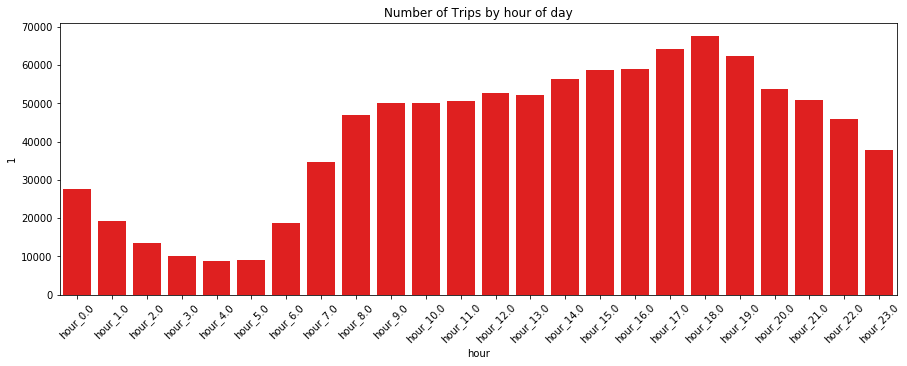

In [11]:
hours_sm = pd.DataFrame(data = df.iloc[:,29:53].apply(lambda x: x.value_counts()).T.rename_axis('hour').reset_index())

plt.figure(figsize=(15,5))
plt.xticks(rotation=45)
sns.barplot(x = hours_sm['hour'], y = hours_sm[1], color = "red").set_title("Number of Trips by hour of day")

### Total Fare Amount

Text(0.5, 1.0, 'Total Fare Amount')

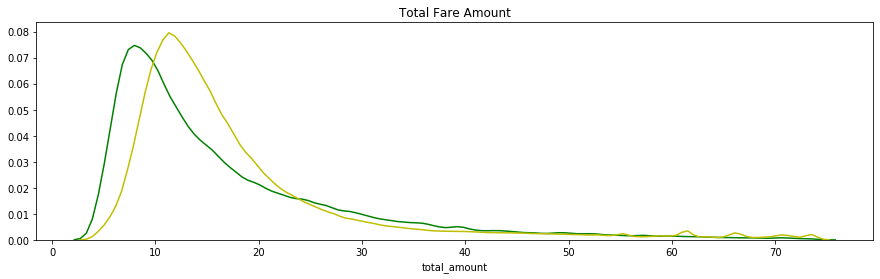

In [12]:
plt.figure(figsize=(15,4))
sns.distplot(df[df['cab'] == 'green']['total_amount'], hist=False, color = "green")
sns.distplot(df[df['cab'] == "yellow"]['total_amount'], hist=False, color = "y").set_title('Total Fare Amount')

In [13]:
df.groupby('cab')['total_amount'].mean()

cab
green     17.033638
yellow    18.199044
Name: total_amount, dtype: float64

On average, the total fare amount for yellow cabs is slightly greater than green cabs. We can check if this is due to longer trip times & higher distances traveled in yellow cabs than green cabs, shown below:

### Total Trip Time

Text(0.5, 1.0, 'Total Trip Time')

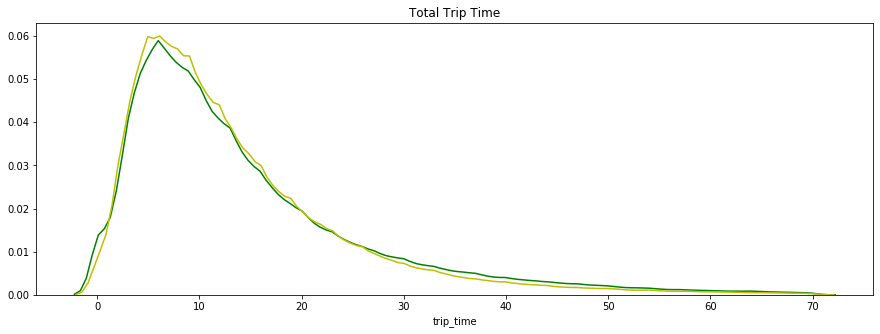

In [14]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=="green"]['trip_time'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['trip_time'], hist = False, color = "y").set_title('Total Trip Time')

In [15]:
df.groupby('cab')['trip_time'].mean()

cab
green     14.628714
yellow    13.715370
Name: trip_time, dtype: float64

Text(0.5, 1.0, 'Total Trip Distance')

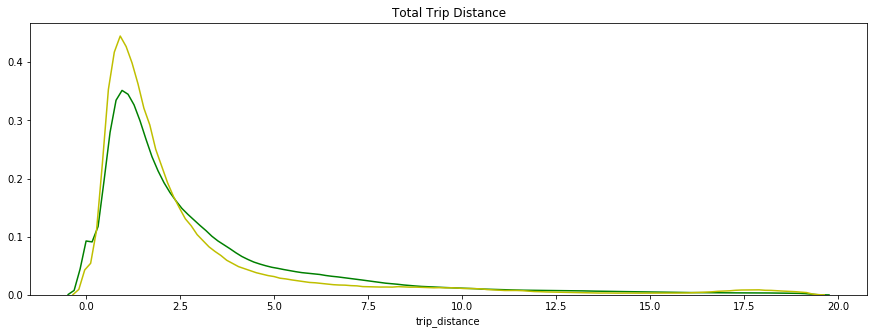

In [16]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=="green"]['trip_distance'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['trip_distance'], hist = False, color = "y").set_title('Total Trip Distance')

In [17]:
df.groupby('cab')['trip_distance'].mean()

cab
green     3.117251
yellow    2.803687
Name: trip_distance, dtype: float64

On average, the trip times and distances are approximately the same between both cabs (13-14 minutes and 3 miles, respectively).

### Total Tip Amount

Text(0.5, 1.0, 'Total Tip Amount')

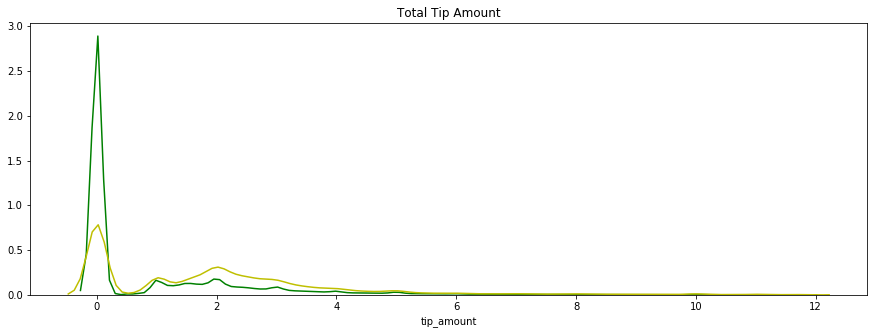

In [18]:
plt.figure(figsize=(15,5))
sns.distplot(df[df['cab']=="green"]['tip_amount'], hist = False, color = "green")
sns.distplot(df[df['cab']=="yellow"]['tip_amount'], hist = False, color = "y").set_title('Total Tip Amount')

In [19]:
df[df['tip_amount'] == 0].groupby('cab')['tip_amount'].count()

cab
green     322657
yellow    154919
Name: tip_amount, dtype: int64

In [20]:
df[df['tip_amount'] > 0].groupby('cab')['tip_amount'].count()

cab
green     175949
yellow    336500
Name: tip_amount, dtype: int64

There are a large portion of transactions have 0 tips for both cabs. 
* For green, approximately 60% of all transactions don't have tips.
* For yellow, approximately 30% of all transactions dont have tips.

Most of the 0 tip transactions are cash **(shown below - 'payment_type = 2')**.
* 87% of no-tip transactions in yellow cabs are cash (9% are credit card)
* 61% of no-tip transactions in green cabs are cash (27% are credit card).

This could mean that taxi cab drivers do not record tip amounts for cash transcations (possibly for tax reasons).

In [21]:
df[df['tip_amount'] == 0].groupby(['cab', 'payment_type'])['payment_type'].count()

cab     payment_type
green   1.0              87903
        2.0             196887
        3.0               2430
        4.0               1043
        5.0                  8
yellow  1.0              14315
        2.0             135435
        3.0               2645
        4.0               1089
Name: payment_type, dtype: int64

### Total Transactions with No Tip (Removing all Cash Transactions)

In [55]:
df_nocash = df[df['payment_type'] != 2]
df_nocash[df_nocash['tip_amount'] == 0].groupby('cab')['tip_amount'].count()

cab
green     125770
yellow     19484
Name: tip_amount, dtype: int64

### Trip Speed vs. Tip Amount

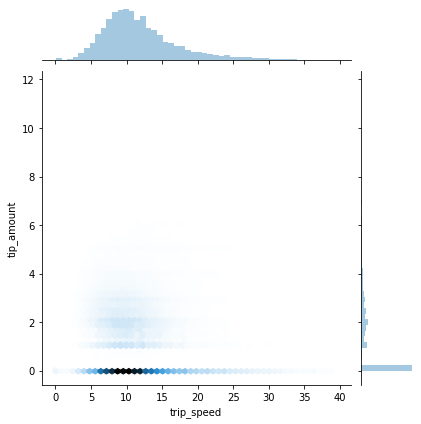

In [23]:
sns.jointplot('trip_speed', 'tip_amount', data = df, kind = 'hex')

In [24]:
# Pearson correlation coefficient of trip speed and tip amount:
df[['trip_speed','tip_amount']].corr()

,trip_speed,tip_amount
trip_speed,1.000000,0.120213
tip_amount,0.120213,1.000000


There is a weak correlation between trip speed and the tip amount.

### Summary of Tips by Payment Type & Borough

In [25]:
df.groupby(['cab', 'payment_type'])['tip_amount'].describe()

count      mean       std  min   25%   50%   75%  \
cab    payment_type                                                        
green  1.0           263791.0  1.774848  1.901723  0.0  0.00  1.50  2.61   
       2.0           196894.0  0.000077  0.019249  0.0  0.00  0.00  0.00   
       3.0             2430.0  0.000000  0.000000  0.0  0.00  0.00  0.00   
       4.0             1044.0  0.002347  0.075826  0.0  0.00  0.00  0.00   
       5.0                8.0  0.000000  0.000000  0.0  0.00  0.00  0.00   
yellow 1.0           350797.0  2.762573  1.935048  0.0  1.66  2.26  3.30   
       2.0           135446.0  0.000145  0.018340  0.0  0.00  0.00  0.00   
       3.0             2645.0  0.000000  0.000000  0.0  0.00  0.00  0.00   
       4.0             1091.0  0.006059  0.152887  0.0  0.00  0.00  0.00   

                       max  
cab    payment_type         
green  1.0           11.75  
       2.0            7.66  
       3.0            0.00  
       4.0            2.45  
       5.0            0.00  
yellow 1.0           11.75  
       2.0            4.16  
       3.0            0.00  
       4.0            4.66

In [26]:
df.groupby('Borough')['tip_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Borough,,,,,,,,
Bronx,36275.0,0.193213,0.944198,0.0,0.0,0.0,0.00,11.67
Brooklyn,148938.0,1.098120,1.798138,0.0,0.0,0.0,1.95,11.72
EWR,31.0,3.152581,4.500166,0.0,0.0,0.0,8.50,11.00
Manhattan,622372.0,1.660960,1.788879,0.0,0.0,1.5,2.56,11.75
Queens,176290.0,1.268870,2.435158,0.0,0.0,0.0,1.70,11.75
Staten Island,239.0,0.360084,1.205037,0.0,0.0,0.0,0.00,6.94
Unknown,5880.0,1.605840,2.194837,0.0,0.0,1.0,2.36,11.75


## Modeling

Models to consider:
* Zero Inflated
* Random Forest
* XGBoost
* Neural Net
* KNN
* Logistic Regression (to predict action of tipping)